# Loading Libraries

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, callbacks, optimizers, models

In [2]:
class_names = [f'digit_{i}' for i in range(10)]

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_digits_loader = train_datagen.flow_from_directory(
        'data/Train',
        target_size=(32, 32),
        classes = class_names,
        batch_size=32,
        color_mode = 'grayscale',
        class_mode='categorical')

test_digits_loader = test_datagen.flow_from_directory(
        'data/Test',
        target_size=(32, 32),
        classes = class_names,
        color_mode = 'grayscale',
        batch_size=1,
        shuffle = False,
        seed = 2076,
        class_mode='categorical')

Found 17000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


# Data Visualization

In [5]:
def plot_image(img_path_index):
  img_path = train_digits_loader.filepaths[img_path_index]
  a = Image.open(img_path)
  arr = np.array(a)
  plt.imshow(arr,cmap= 'gray')
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])


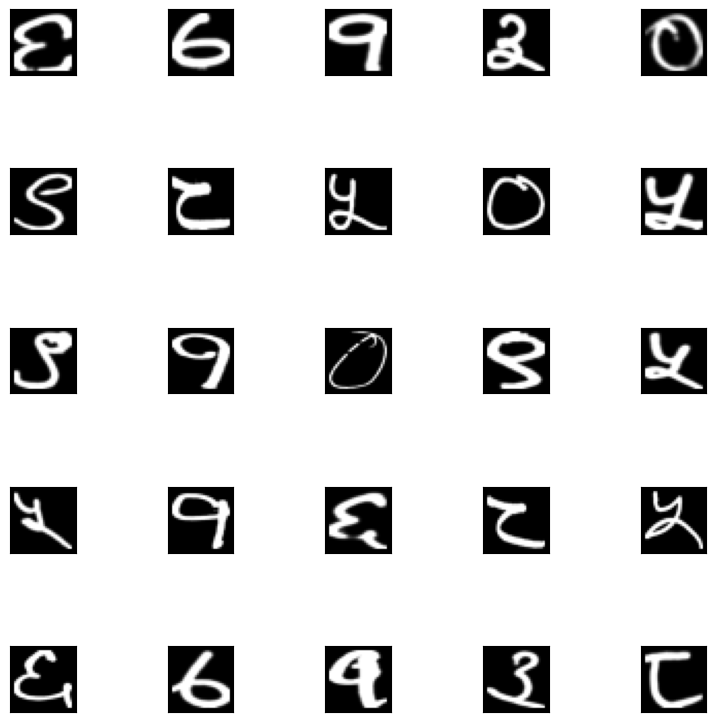

In [7]:
# plotting 20 random images from training set
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 *num_cols, 2*i + 1)
  rand_index = random.randint(1,17000)
  plot_image(rand_index)
plt.show()

# Model Building and Training

In [10]:
# CNN model creation
def cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64,(3,3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    opt = optimizers.Adam(learning_rate=0.0015, beta_1=0.9, beta_2=0.99, epsilon=None, amsgrad=False)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [11]:
model = cnn_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1024)             

In [12]:
# callbacks for saving models
filepath = 'cnn-{val_acc: 5.3f}.h5'
model_save = callbacks.ModelCheckpoint(filepath, monitor= 'val_acc', save_best_only=True)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience =4)

In [13]:
def plot_acc(history):
  plt.plot(history.epoch, history.history['val_acc'] )
  plt.plot(history.epoch, history.history['acc'])
  plt.legend(['val_acc', 'train acc'])


In [59]:
sample_size = train_digits_loader.n
batch_size = 32

hist = model.fit_generator(
    train_digits_loader,
    steps_per_epoch=sample_size // batch_size,
    epochs=50,
    validation_data=test_digits_loader,
    validation_steps=3000 ,
    callbacks=[model_save, early_stop]
)

Epoch 1/50
531/531 [==============================] - 35s 66ms/step - loss: 0.2625 - acc: 0.9131 - val_loss: 0.0544 - val_acc: 0.9860
Epoch 2/50
531/531 [==============================] - 35s 67ms/step - loss: 0.0509 - acc: 0.9852 - val_loss: 0.0447 - val_acc: 0.9883
Epoch 3/50
531/531 [==============================] - 37s 69ms/step - loss: 0.0274 - acc: 0.9915 - val_loss: 0.0333 - val_acc: 0.9917
Epoch 4/50
531/531 [==============================] - 35s 65ms/step - loss: 0.0202 - acc: 0.9935 - val_loss: 0.0398 - val_acc: 0.9907
Epoch 5/50
531/531 [==============================] - 36s 68ms/step - loss: 0.0129 - acc: 0.9963 - val_loss: 0.0334 - val_acc: 0.9913
Epoch 6/50
531/531 [==============================] - 35s 66ms/step - loss: 0.0089 - acc: 0.9971 - val_loss: 0.0295 - val_acc: 0.9937
Epoch 7/50
531/531 [==============================] - 36s 68ms/step - loss: 0.0078 - acc: 0.9975 - val_loss: 0.0290 - val_acc: 0.9930
Epoch 8/50
531/531 [==============================] - 34s 64ms

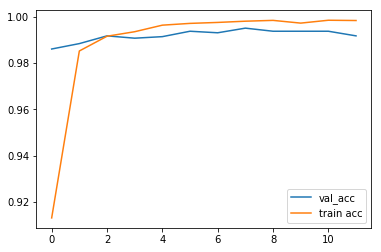

In [60]:
plot_acc(hist)

# Model Loading, Evaluation and Testing

In [15]:
classifier = models.load_model('digit_99.h5')

In [20]:
classifier.evaluate(test_digits_loader, steps = 3000)

3000/3000 [==============================] - 8s 3ms/step - loss: 0.0294 - accuracy: 0.9943


[0.029359042644500732, 0.9943333268165588]

In [21]:
# Testing
test_digits_loader.reset()
true_labels = test_digits_loader.classes
predictions_with_prob = classifier.predict(test_digits_loader, steps = 3000)

3000/3000 [==============================] - 8s 3ms/step


In [22]:
predictions = np.argmax(predictions_with_prob, axis= 1)

In [31]:
predictions

array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

In [23]:
incorrect_predictions = np.nonzero(predictions - true_labels)

In [24]:
incorrect_predictions

(array([ 428,  729,  752,  775,  839,  949, 1022, 1023, 1445, 1771, 2026,
        2356, 2609, 2709, 2934, 2942, 2965], dtype=int64),)

In [33]:
# Finding indices of instances where predictions are incorrect (false negatives)
incorrect_predictions_indices = np.nonzero(predictions != true_labels)[0]

In [34]:
# Filtering out indices corresponding to false positives (predicted negative, true positive)
false_negatives_indices = [i for i in incorrect_predictions_indices if predictions[i] == 0 and true_labels[i] == 1]

In [35]:
# Calculateing the number of false negatives
false_negatives = len(false_negatives_indices)

In [25]:
for _ in range(10):
  rand_index = random.randint(0,3000)
  print(f'True label: {true_labels[rand_index]} , Predicted label: {predictions[rand_index]} for index {rand_index}')

True label: 1 , Predicted label: 1 for index 520
True label: 5 , Predicted label: 5 for index 1640
True label: 8 , Predicted label: 8 for index 2494
True label: 5 , Predicted label: 5 for index 1518
True label: 1 , Predicted label: 1 for index 500
True label: 3 , Predicted label: 3 for index 1070
True label: 8 , Predicted label: 8 for index 2496
True label: 9 , Predicted label: 9 for index 2733
True label: 2 , Predicted label: 2 for index 817
True label: 0 , Predicted label: 0 for index 290


In [26]:
# function to plot image with predictions percentages
def plot_predicted_image(i, predictions_array, true_labels, img_generator):
  predicted_label, true_label, img = predictions_array[i], true_labels[i], img_generator[i][0]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  reshaped_img = img.reshape(32,32)
  plt.imshow(reshaped_img, cmap=plt.cm.binary)
  plt.title(f' Predicted {true_label } for {predicted_label}  digit')


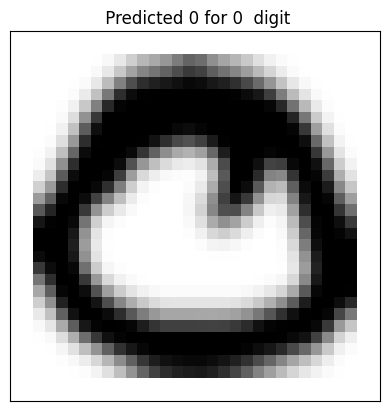

In [27]:
plot_predicted_image(100, predictions, true_labels, test_digits_loader)

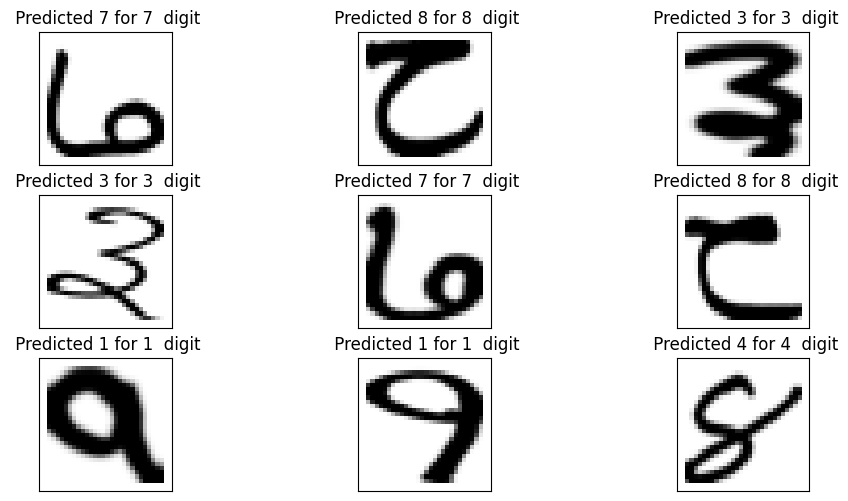

In [29]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 *num_cols, 2*i + 1)
  rand_idx = random.randint(0,3000)
  plot_predicted_image(rand_idx, predictions, true_labels, test_digits_loader)
plt.show()

# Plotting incorrect prediction

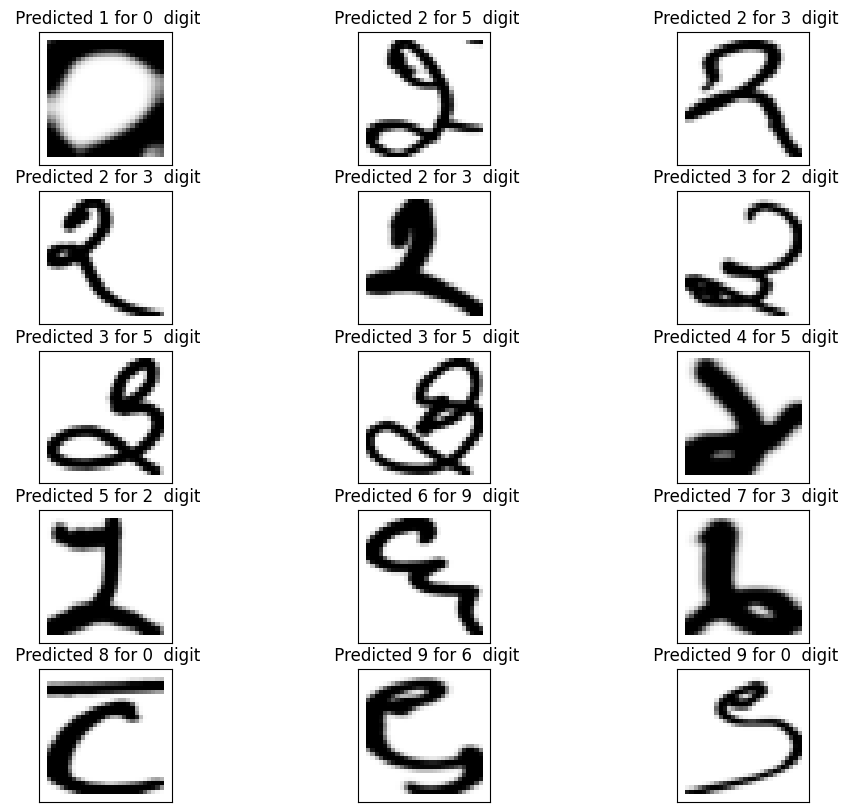

In [30]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 *num_cols, 2*i + 1)
  plot_predicted_image(incorrect_predictions[0][i], predictions, true_labels, test_digits_loader)
plt.show()

# Assessment of Classifier

In [38]:
# Calculating true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN)
TP = np.sum((predictions == 1) & (true_labels == 1))
FP = np.sum((predictions == 1) & (true_labels == 0))
TN = np.sum((predictions == 0) & (true_labels == 0))
FN = np.sum((predictions == 0) & (true_labels == 1))

In [39]:
# Calculating precision, recall, F1 score, and accuracy
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)

In [40]:
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Accuracy:", accuracy)

Precision: 1.0
Recall: 0.9966666666666667
F1 Score: 0.9983305509181971
Accuracy: 0.9983333333333333
